In [1]:
import do_mpc
import numpy as np

In [2]:
dt = 0.1

In [3]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [4]:
# position (x, y, z)
x = model.set_variable(var_type='_x', var_name='x', shape=(3,1))
# velocity (dx, dy, dz)
dx = model.set_variable(var_type='_x', var_name='dx', shape=(3,1))
# controls (u1, u2, u3)
u = model.set_variable(var_type='_u', var_name='u', shape=(3,1))
# distance to obstacle
#d_obs = model.set_variable(var_type='_x', var_name='d_obs')

# obstacle postion
x_obs = model.set_variable(var_type='_p', var_name='x_obs', shape=(3,1))
# collision avoidance expession
#d_obs = model.set_expression(expr_name="d_obs", expr=(x[0] - x_obs[0])**2 + (x[1] - x_obs[1])**2 + (x[2] - x_obs[2])**2)



In [5]:
# system dynamics
model.set_rhs('x', x + dx * dt)
model.set_rhs('dx', u)
#model.set_rhs('d_obs', (x[0] - x_obs[0])**2 + (x[1] - x_obs[1])**2 + (x[2] - x_obs[2])**2)

# setup model
model.setup()

In [6]:
mpc = do_mpc.controller.MPC(model)


In [7]:
setup_mpc = {
    'n_horizon': 20,
    't_step': dt,
    'store_full_solution': True,
}

mpc.set_param(**setup_mpc)

In [8]:
# desired position
x_d = np.array([1., 1., 1.])

mterm = (x[0] - x_d[0])**2 + (x[1] - x_d[1])**2 + (x[2] - x_d[2])**2
lterm = (x[0] - x_d[0])**2 + (x[1] - x_d[1])**2 + (x[2] - x_d[2])**2

mpc.set_objective(mterm=mterm, lterm=lterm)

In [9]:
# Upper bounds on inputs:
mpc.bounds['upper','_u', 'u'] = 0.5 * np.ones((3, 1))
# Lower bounds on inputs:
mpc.bounds['lower','_u', 'u'] = -0.5 * np.ones((3, 1))

# collision avoidance constraint
mpc.set_nl_cons('d_obs', -( (x[0] - x_obs[0])**2 + (x[1] - x_obs[1])**2 + (x[2] - x_obs[2])**2 ), ub=-0.01, soft_constraint=True, penalty_term_cons=1e6)


SX((-((sq((x_0-x_obs_0))+sq((x_1-x_obs_1)))+sq((x_2-x_obs_2)))))

In [10]:
mpc.set_uncertainty_values(
    x_obs = np.array([[0.5, 0.5, 0.5]])
)

In [11]:
mpc.setup()


/home/vateseifelfrej/anaconda3/envs/safepanda/lib/python3.9/site-packages/do_mpc/controller/_mpc.py:787: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [12]:
x0 = np.zeros((6,))
mpc.x0 = x0

In [13]:
mpc.set_initial_guess()

In [14]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      306
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:       63

Total number of variables............................:      206
                     variables with only lower bounds:       20
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:      126
Total number of inequality c

In [15]:
x_scp = []
for i in range(len(mpc.opt_x_num['_x', :, 0, 0])):
  x_scp.append(mpc.opt_x_num['_x', :, 0, 0][i].toarray()[:3].squeeze())

In [16]:
x_scp = np.array(x_scp)

In [17]:
x_scp

array([[ 1.29674008e-31, -3.62171304e-34, -3.63376035e-33],
       [-5.31308452e-34, -1.30282782e-34, -6.40618810e-35],
       [ 4.99989073e-02,  4.99979802e-02,  4.99989073e-02],
       [ 9.99977156e-02,  9.99955948e-02,  9.99977156e-02],
       [ 1.49996412e-01,  1.49992716e-01,  1.49996412e-01],
       [ 1.99994982e-01,  1.99989137e-01,  1.99994982e-01],
       [ 2.49993408e-01,  2.49984498e-01,  2.49993408e-01],
       [ 2.99991671e-01,  2.99978076e-01,  2.99991671e-01],
       [ 3.49989746e-01,  3.49968057e-01,  3.49989746e-01],
       [ 3.99987607e-01,  3.99947193e-01,  3.99987607e-01],
       [ 4.49985224e-01,  4.29288232e-01,  4.49985224e-01],
       [ 4.99982773e-01,  3.99979150e-01,  4.99982771e-01],
       [ 5.49980055e-01,  4.29257367e-01,  5.49980054e-01],
       [ 5.99973102e-01,  4.79252839e-01,  5.99973101e-01],
       [ 6.49964163e-01,  5.29247261e-01,  6.49964162e-01],
       [ 6.99952246e-01,  5.79240203e-01,  6.99952245e-01],
       [ 7.49935568e-01,  6.29230953e-01

In [18]:
# obstacle
x_obs = 0.5*np.ones(3)
r_obs = 0.1


In [19]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d

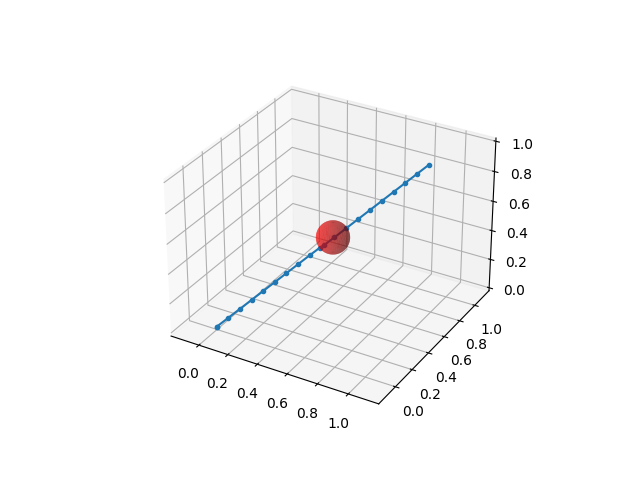

In [20]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.axis('equal')
# Plot the trajectory
ax.plot(x_scp[:,0], x_scp[:,1], x_scp[:,2], '.-')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x_sphere = x_obs[0] + r_obs * np.outer(np.cos(u), np.sin(v))
y_sphere = x_obs[1] + r_obs * np.outer(np.sin(u), np.sin(v))
z_sphere = x_obs[2] + r_obs * np.outer(np.ones(np.size(u)), np.cos(v))
sphere = ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.5)